## Exercise 1

Find an optimal learning rate for the handwriting MNIST data.  After this, verify that your learning rate achieves better performance than values that are either larger or smaller.

In [1]:
import tensorflow as tf
import math
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = self.model.optimizer.learning_rate * self.factor

2024-04-11 14:49:44.311170: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 14:49:45.667784: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 14:49:48.820052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 14:49:52.500931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [3]:
import matplotlib.pyplot as plt

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1142 - loss: 2.4671


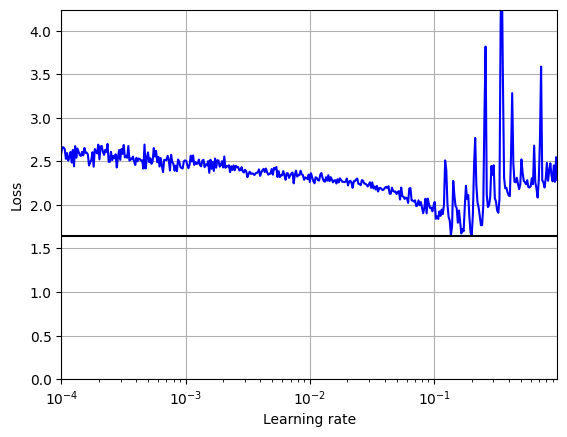

In [21]:
import numpy as np

mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full , X_test = X_train_full / 255, X_test / 255

noise_factor = 0.8
train_images_noisy = X_train_full + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_full.shape) 
test_images_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

X_train, y_train = train_images_noisy[:-5000], y_train_full[:-5000]
X_valid, y_valid = train_images_noisy[-5000:], y_train_full[-5000:]


def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation = "relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [19]:
optimal_lr = 10**-.9
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Epoch 1/10


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5305 - loss: 1.3448 - val_accuracy: 0.7888 - val_loss: 0.6314
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7635 - loss: 0.7064 - val_accuracy: 0.8108 - val_loss: 0.5800
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8067 - loss: 0.5796 - val_accuracy: 0.8092 - val_loss: 0.5734
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8326 - loss: 0.4992 - val_accuracy: 0.8080 - val_loss: 0.5982
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8525 - loss: 0.4382 - val_accuracy: 0.8056 - val_loss: 0.6162
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8710 - loss: 0.3842 - val_accuracy: 0.8064 - val_loss: 0.6709
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8824 - loss: 0.3443 - val_accuracy: 0.7968 - val_loss: 0.7370
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8953 - loss: 0.3055 - val_accurac

## Exercise 2

Compare a one cycle learning rate schedule to a power law schedule for the handwriting data.  Which can you make perform more effectively?

## Exercise 3

Re-run all of the code in the second notebook with the handwriting data, instead of the fashion data; graph your losses (training and validation).  Do you achieve similar results?

Epoch 1/10


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5323 - loss: 1.3304 - val_accuracy: 0.7834 - val_loss: 0.6776
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7684 - loss: 0.6902 - val_accuracy: 0.7888 - val_loss: 0.6382
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8154 - loss: 0.5585 - val_accuracy: 0.8024 - val_loss: 0.6223
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8427 - loss: 0.4713 - val_accuracy: 0.8058 - val_loss: 0.6369
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8661 - loss: 0.4027 - val_accuracy: 0.8026 - val_loss: 0.6698
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8826 - loss: 0.3493 - val_accuracy: 0.8062 - val_loss: 0.6930
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8951 - loss: 0.3044 - val_accuracy: 0.8070 - val_loss: 0.7222
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9045 - loss: 0.2715 - val_accurac

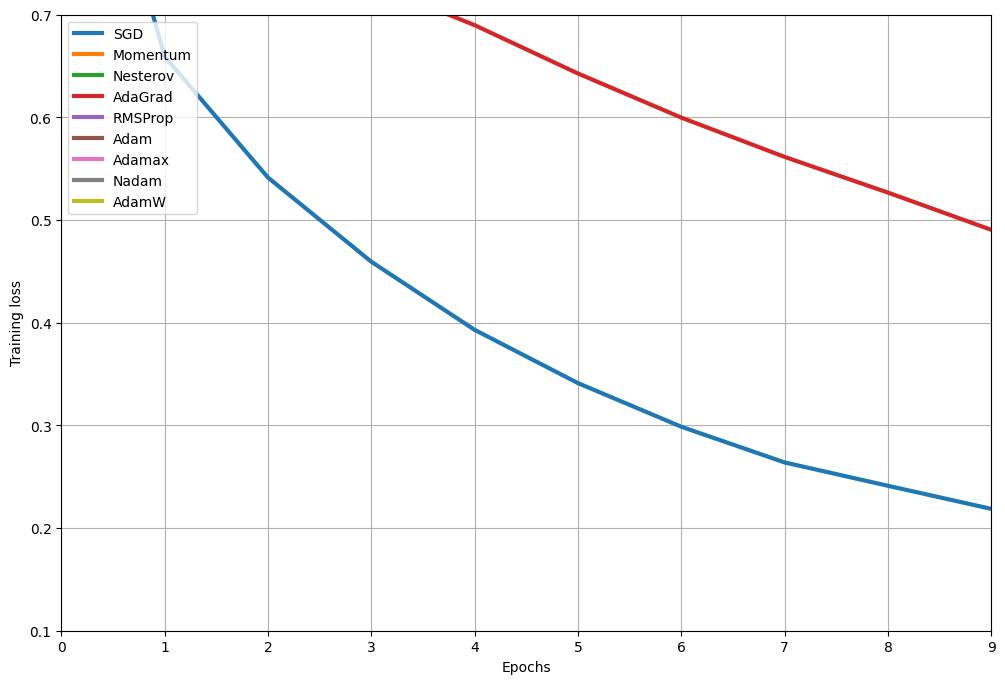

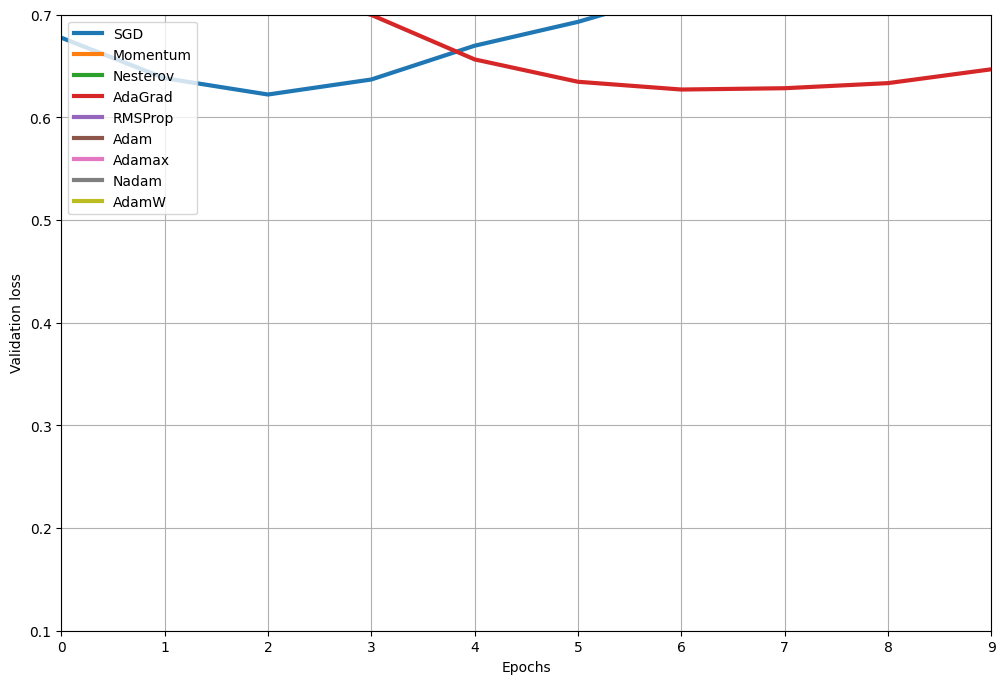

In [22]:
optimal_lr = 10 ** -.9

optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
history_sgd = build_and_train_model(optimizer)

optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr, momentum=.9)
history_momentum = build_and_train_model(optimizer)

optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr, momentum=0.9,
                                    nesterov=True)
history_nesterov = build_and_train_model(optimizer) 

optimizer = tf.keras.optimizers.Adagrad(learning_rate=optimal_lr)
history_adagrad = build_and_train_model(optimizer)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=optimal_lr, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

optimizer = tf.keras.optimizers.Adam(learning_rate=optimal_lr, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer)

optimizer = tf.keras.optimizers.Adamax(learning_rate=optimal_lr, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

optimizer = tf.keras.optimizers.Nadam(learning_rate=optimal_lr, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=optimal_lr,
                                 beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer) 

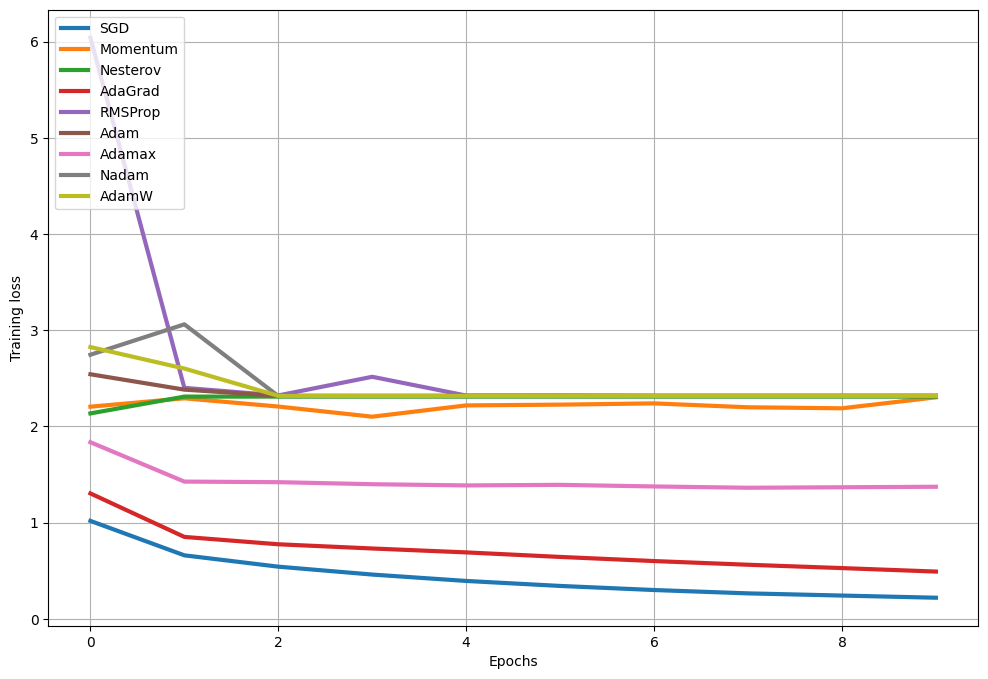

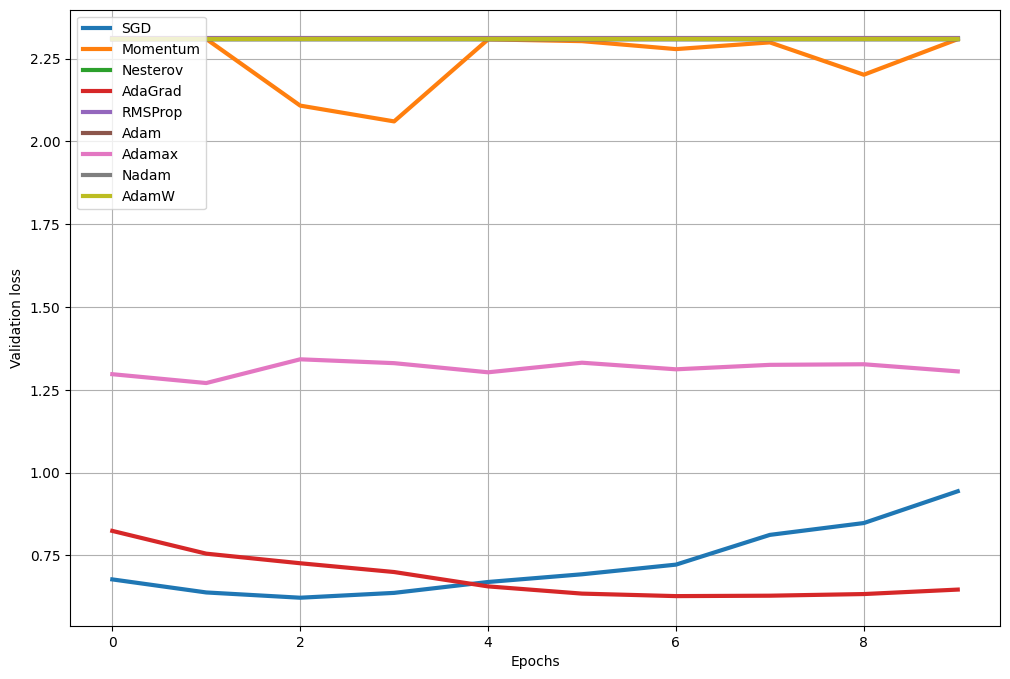

In [23]:

import matplotlib.pyplot as plt
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.show()

## Exercise 4

Sometimes, adaptive optimizers fail, and non-adaptive optimizers like NAG or SGD perform a lot better.  This is sometimes the case with noisy data.

In the following, I've create a simple framework to examine the behavior of different optimizers with different noise levels.  Try running with an adaptive optimizer (AdamW) and a non-adaptive optimizer (NAG / SGD) with different levels of noise.  Do you find a point with NAG starts to outperform AdamW?  What happens if you adjust learning rates?

In [34]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add noise
noise_factor = 0.15
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

# Define a simple neural network model
def create_model(optimizer):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

optimal_lr = 10 ** -.9

def build_and_train_model(optimizer):
    model = create_model(optimizer)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [35]:
optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=optimal_lr,
                                 beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1040 - loss: 3.8990 - val_accuracy: 0.1060 - val_loss: 2.3095
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1046 - loss: 2.3699 - val_accuracy: 0.1060 - val_loss: 2.3096
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1040 - loss: 2.3153 - val_accuracy: 0.1060 - val_loss: 2.3096
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1040 - loss: 2.3153 - val_accuracy: 0.1060 - val_loss: 2.3096
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1040 - loss: 2.3154 - val_accuracy: 0.1060 - val_loss: 2.3096
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1040 - loss: 2.3154 - val_accuracy: 0.1060 - val_loss: 2.3096
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1040 - loss: 2.3154 - val_accuracy: 0.1060 - val_loss: 2.3096
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1040 - loss: 2.3154 - 

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5353 - loss: 1.3366 - val_accuracy: 0.7776 - val_loss: 0.6508
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7748 - loss: 0.6747 - val_accuracy: 0.8064 - val_loss: 0.5835
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8189 - loss: 0.5404 - val_accuracy: 0.8238 - val_loss: 0.5538
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8496 - loss: 0.4547 - val_accuracy: 0.8176 - val_loss: 0.5827
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8693 - loss: 0.3898 - val_accuracy: 0.8164 - val_loss: 0.6049
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8870 - loss: 0.3382 - val_accuracy: 0.8174 - val_loss: 0.6644
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9015 - loss: 0.2916 - val_accuracy: 0.8054 - val_loss: 0.7631
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9081 - loss: 0.2630 - 